In [57]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot
from sklearn import preprocessing

In [58]:
# Loading the MNIST datasets - 60000 images for training and 10000 images for testing
(imageTrainRaw, labelTrainRaw), (imageTestRaw, labelTestRaw) = tf.keras.datasets.mnist.load_data()

# Splitting the training set into 2: 55000 images for training and 5000 images for validation
imageTestRaw = imageTestRaw[:]
labelTestRaw = labelTestRaw[:]
imageValidRaw = imageTrainRaw[55000:]
labelValidRaw = labelTrainRaw[55000:]
imageTrainRaw = imageTrainRaw[:55000]
labelTrainRaw = labelTrainRaw[:55000]


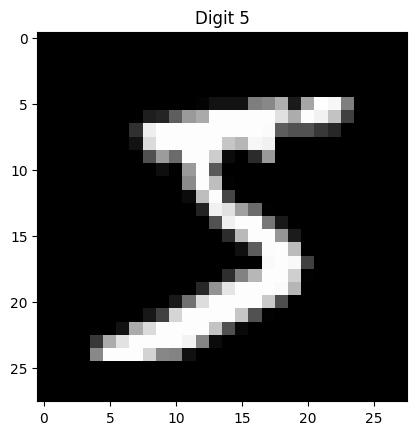

In [59]:
# Plotting an image
def plotImage(idx):
    pyplot.title(f"Digit {labelTrainRaw[idx]}")
    pyplot.imshow(imageTrainRaw[idx], cmap='gray')
    pyplot.savefig("./test/digitGrey.jpg")
    
plotImage(idx = 0)

In [60]:
# Preprocessing data (normalizing image arrays and 1-hot encoding label arrays)
imageTest = np.reshape(imageTestRaw, (10000, 784))
imageTest = preprocessing.normalize(imageTest, norm = "max")
labelTest = tf.keras.utils.to_categorical(labelTestRaw, num_classes=10)

imageValid = np.reshape(imageValidRaw, (5000, 784))
imageValid = preprocessing.normalize(imageValid, norm = "max")
labelValid = tf.keras.utils.to_categorical(labelValidRaw, num_classes=10)

imageTrain = np.reshape(imageTrainRaw, (55000, 784))
imageTrain = preprocessing.normalize(imageTrain, norm="max")
labelTrain = tf.keras.utils.to_categorical(labelTrainRaw, num_classes=10)

In [61]:
# Setting up the neural network layer dimension and hypermeters 
iter = 10000    # Number of iterations
size = 55000    # Number of inputs
batchSize = 50  # Size of mini-batch GD
etaInit = 0.01  # Initial learning rate
etaDecay = 1    # Learning rate decay
dInput = 784    # Input layer (28x28 pixels)
dHidden = 400   # Hidden layer (16x16 pixel)
dOutput = 10    # Output layer (0-9 digits)

In [62]:
# ReLU activation for hidden layer
def relu(x):
    return np.maximum(0, x)

# Softmax activation for output layer
def softmax(x):
    c = np.max(x, axis = 0, keepdims = True)
    x -= c
    e = np.exp(x)
    return e / sum(e)

# Calculating loss value using cross entropy
def floss(yCal, yLabel):
    result = -np.sum(np.log(yCal) * yLabel) / batchSize
    return result

In [63]:
# Initializing weights, biases and eta
w1 = 0.01 * np.random.rand(dInput, dHidden)
b1 = 0.01 * np.random.rand(dHidden, batchSize)
w2 = 0.01 * np.random.rand(dHidden, dOutput)
b2 = 0.01 * np.random.rand(dOutput, batchSize)
eta = etaInit

lossPrev = 1000
for n in range(iter + 1):
    idxList = np.random.randint(55000, size=batchSize)
    # Feed forward
    x = imageTrain[idxList].T
    z1 = np.dot(w1.T, x) + b1
    a1 = relu(z1)
    z2 = np.dot(w2.T, a1) + b2
    a2 = softmax(z2)
    yCal = a2 
    yLabel = labelTrain[idxList].T
    loss = floss(yCal, yLabel) 
    if(loss < lossPrev):
        lossPrev = loss
        w1Res = w1
        b1Res = b1
        w2Res = w2
        b2Res = b2
        print(f"[Iter {n}] Loss: {loss}")
        
    # Back propagation
    e2 = (yCal - yLabel) / batchSize   # gradient of softmax using cross entropy
    dw2 = np.dot(a1, e2.T)
    db2 = sum(e2)
    e1 = np.dot(w2, e2)
    e1[z1 <= 0] = 0                    # gradient of ReLU
    dw1 = np.dot(x, e1.T)
    db1 = sum(e1)

    # Updating weights and biases
    w1 += -eta * dw1
    b1 += -eta * db1
    w2 += -eta * dw2
    b2 += -eta * db2


[Iter 0] Loss: 2.3019720946968416
[Iter 2] Loss: 2.2967432567937265
[Iter 7] Loss: 2.261041045206833
[Iter 9] Loss: 2.2192570737106854
[Iter 133] Loss: 2.189421644630764
[Iter 273] Loss: 2.172549405973304
[Iter 286] Loss: 2.1585551972114705
[Iter 359] Loss: 2.1356571720989495
[Iter 360] Loss: 2.1000154194118266
[Iter 397] Loss: 2.0975715746248325
[Iter 407] Loss: 2.0783440667594575
[Iter 429] Loss: 2.055639752109071
[Iter 447] Loss: 2.0502618646580952
[Iter 448] Loss: 2.0483972582901937
[Iter 453] Loss: 2.045354550947013
[Iter 461] Loss: 2.0381022787152863
[Iter 462] Loss: 2.027288531007217
[Iter 467] Loss: 2.0272190265351147
[Iter 469] Loss: 2.026723818578662
[Iter 471] Loss: 2.009725145066069
[Iter 475] Loss: 1.9791240911007508
[Iter 485] Loss: 1.978566597082701
[Iter 487] Loss: 1.967012177072063
[Iter 492] Loss: 1.9561647137122815
[Iter 497] Loss: 1.9252220125286983
[Iter 500] Loss: 1.8527615578503571
[Iter 512] Loss: 1.8515481201668769
[Iter 522] Loss: 1.8356696696562622
[Iter 544]

In [74]:
count = 0
epoch = 0
while epoch < 5000:
    idxList = np.arange(epoch, epoch + 50, 1)
    x = imageTrain[idxList].T
    z1 = np.dot(w1Res.T, x) + b1Res
    a1 = relu(z1)
    z2 = np.dot(w2Res.T, a1) + b2Res
    a2 = softmax(z2)
    yLabel = labelTrain[idxList]
    prediction = np.argmax(a2.T, axis=1)
    answer = np.argmax(yLabel, axis = 1)
    for n in range(50):
        if(prediction[n] == answer[n]):
            count += 1
    epoch += 50

print(count / 5000)

0.9252


In [ ]:
count = 0
idxList = np.arange(0, 50, 1)
x = imageTrain[idxList].T
z1 = np.dot(w1Res.T, x) + b1Res
a1 = relu(z1)
z2 = np.dot(w2Res.T, a1) + b2Res
a2 = softmax(z2)
yLabel = labelTrain[idxList]
prediction = np.argmax(a2.T, axis=1)
answer = np.argmax(yLabel, axis = 1)
for n in range(50):
    if(prediction[n] == answer[n]):
        count += 1
        
print(count / 50)